# Astrometry Response functions (Maps)

In [1]:
import numpy as np
import matplotlib
from matplotlib import colormaps
import matplotlib.pyplot as plt
import healpy as hp
import itertools

In [2]:
# Going from ecliptic coordinates to spherical ones.
# Velocity with respect to the cosmic frame (in galactic coordinates(l, b) = (264◦, 48◦)):
v_theta = (np.pi/2)-np.radians(-7.145) # (pi/2 - Declination) E[0,pi]
v_phi = np.radians(167.78) # Right Ascension E[0,2pi]

In [3]:
# unit vector in R3. 
# Given two angles, \theta E[0,pi] and \phi E[0,2pi], the next function retuns its cartesian coordinates
def skyvec(theta,phi): 
    st = np.sin(theta)
    cp = np.cos(phi)
    sp = np.sin(phi)
    ct = np.cos(theta)
    return np.array([st*cp,st*sp,ct])

## Ploting random stars in the Sky

In [4]:
np.random.seed(3)
n_stars = 4
npair = n_stars*(n_stars -1)/2
theta = np.random.uniform(0, np.pi, n_stars)  # colatitude E[0, pi]
phi = np.random.uniform(0, 2*np.pi, n_stars) # longitude [0, 2pi]

n1=np.array(skyvec(theta, phi)).reshape(n_stars,3)
n2=np.array(skyvec(theta, phi)).reshape(n_stars,3)
#n1[7]

print(n1)
print(n2[1])
print(npair)

[[ 0.77224408  0.63108403  0.55789047]
 [ 0.26527744 -0.6151315  -0.48135779]
 [ 0.56200905  0.96357213 -0.15890979]
 [-0.60829896  0.61065871 -0.03400937]]
[ 0.26527744 -0.6151315  -0.48135779]
6.0


In [103]:
# Note that alpha and gamma give scalars as result.
def alpha(v,n1,n2):
    cos_zeta = np.dot(n1,n2)
    y = (1- cos_zeta)/2
    n1v = np.dot(n1,v)
    n2v = np.dot(n2,v)
    num = -np.pi*(2*y-1)*(n1v-n2v)*(n1v+n2v)*((y-1)*(2*y+1) - 3*y*np.log(y))
    den = 6*n1v*(y-1)**3
    return num/den

def gamma(v,n1,n2):
    y = (1-np.dot(n1,n2))/2
    n1v = np.dot(n1,v)
    n2v = np.dot(n2,v)
    num = np.pi*y*(n1v+n2v)*((y-1)*(2*y+1) - 3*y*np.log(y))
    den = 3*n1v*((y-1)**2)
    return num/den

#I_3 = np.eye(3)
def delta_ij(i, j):
    return 1 if i == j else 0

#def GTanalytic_Hij_1(v, n1, n2):
#    y = (1-np.dot(n1,n2))/2 # change to zeta if phi is not 0.
#    n1v = np.dot(n1,v)
#    n2v = np.dot(n2,v)
#    alph = alpha(v,n1,n2)
#    gamm = gamma(v,n1,n2)
#    t1 = I_3 * (alph*(2*y+1/(1-2*y) - 1) -2*gamm*n2v)
    #t2 = np.outer(n1, n1)*( alph/(2*y-1) + 2*gamm*n2v) +alph*(np.outer(n1, n2)+np.outer(n2, n1))
    #t3 = np.outer(n2, n2)*alph/(2*y-1) + 2*gamm*(2*y-1)*np.outer(n1, v) + 2*gamm*np.outer(n2, v)
#    return t1+t2+t3 #alpha*coeff_alpha/(2*y-1) + 2*beta*coeff_beta

## Changing the color of the map according to a function

In [104]:
nside = 32
npix = hp.nside2npix(nside)

#frame velocity 
vtheta, vphi = hp.pix2ang(nside, np.arange(npix))
vdir = skyvec(vtheta,vphi).reshape(npix,3) #np.column_stack(skyvec(vtheta,vphi))

#vdir[3000]
#print(vdir[200])
#print(np.outer(vdir[200],n1[1]))
#print(np.outer(vdir[200],n1[1])[2,1])

# Defined to save the results
Hij_1 = np.zeros(npix)
#print(Hij_1)

In [105]:
for k in range(npix):
    for strpair in itertools.combinations(np.arange(n_stars),2):
        for i in range(3):
            for j in range(3):
                idx_p,idx_q = strpair
                I_3= delta_ij(i, j)
                v= vdir[k]
                p= n1[idx_p]
                q= n2[idx_q]
                y = (1-np.dot(p,q))/2
                n1v = np.dot(p,v)
                n2v = np.dot(q,v)
                alph = alpha(v,p,q)
                gamm = gamma(v,p,q)
                t1 = I_3 * (alph*(2*y+1/(1-2*y) - 1) -2*gamm*n2v)
                t2 = np.outer(p, p)[i,j]*(alph/(2*y-1) + 2*gamm*n2v) +alph*(np.outer(p, q)[i,j]+np.outer(q, p)[i,j])
                t3 = np.outer(q, q)[i,j]*alph/(2*y-1) + 2*gamm*(2*y-1)*np.outer(p, v)[i,j] + 2*gamm*np.outer(q, v)[i,j]
                Hij_1+= t1+t2+t3

In [106]:
print(Hij_1)

[-7.80494286 -7.80494286 -7.80494286 ... -7.80494286 -7.80494286
 -7.80494286]


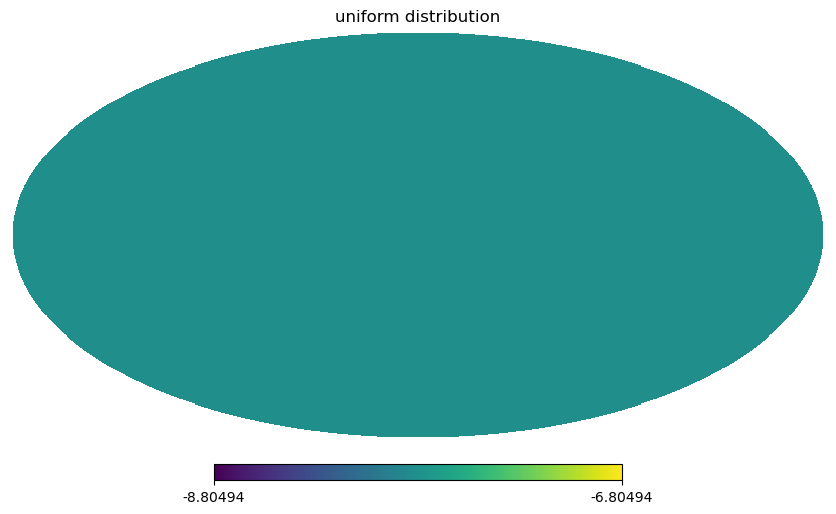

In [107]:
#m = np.arange(len(resultsH0))
hp.mollview(Hij_1,title='uniform distribution')

In [37]:
# Defined to save the results
Hij_1f = np.zeros(npix)

for k in range(npix):
    for m in range(n_stars):
        for n in range(n_stars):
            for i in range(3):
                for j in range(3):
                    I_3= delta_ij(i, j)
                    v= vdir[k]
                    p= n1[m]
                    q= n2[n]
                    y = (1-np.dot(p,q))/2
                    n1v = np.dot(p,v)
                    n2v = np.dot(q,v)
                    alph = alpha(v,p,q)
                    gamm = gamma(v,p,q)
                    t1 = I_3 * (alph*(2*y+1/(1-2*y) - 1) -2*gamm*n2v)
                    t2 = np.outer(p, p)[i,j]*(alph/(2*y-1) + 2*gamm*n2v) +alph*(np.outer(p, q)[i,j]+np.outer(q, p)[i,j])
                    t3 = np.outer(q, q)[i,j]*alph/(2*y-1) + 2*gamm*(2*y-1)*np.outer(p, v)[i,j] + 2*gamm*np.outer(q, v)[i,j]
                    Hij_1f += t1+t2+t3

/var/folders/19/x89tx7bs1ldf399fhwg8hn7w0000gq/T/ipykernel_1852/3577956858.py:7: RuntimeWarning: invalid value encountered in log
  num = -np.pi*(2*y-1)*(n1v-n2v)*(n1v+n2v)*((y-1)*(2*y+1) - 3*y*np.log(y))
/var/folders/19/x89tx7bs1ldf399fhwg8hn7w0000gq/T/ipykernel_1852/3577956858.py:15: RuntimeWarning: invalid value encountered in log
  num = np.pi*y*(n1v+n2v)*((y-1)*(2*y+1) - 3*y*np.log(y))


In [38]:
print(Hij_1f)

[nan nan nan ... nan nan nan]
